In [1]:
# See https://www.tensorflow.org/tutorials/text/image_captioning

# The model architecture is similar to Show, Attend and Tell: Neural Image Caption Generation with Visual Attention.

In [2]:
import tensorflow as tf
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

# Getting the data

In [4]:
# Download COCO  train2014 caption annotation files
annotation_folder = '/coco_annotations_train2014/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                        cache_subdir=os.path.abspath('.'),
                        origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                        extract = True)
    annotation_file = os.path.dirname(annotation_zip)+'/coco_annotations_train2014/captions_train2014.json'
    os.remove(annotation_zip)
else:
    annotation_file = 'coco_annotations_train2014/captions_train2014.json'

147488768/252872794 [================>.............] - ETA: 2:31

KeyboardInterrupt: 

In [4]:
# Download COCO images train2014(241 MB) image files
# The dataset contains over 82,000 images, each of which has at least 5 different caption annotations.
image_folder = '/coco_images_train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                    cache_subdir=os.path.abspath('.'),
                    origin = 'http://images.cocodataset.org/zips/train2014.zip',
                    extract = True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = os.path.abspath('.') + image_folder

In [5]:
PATH

'/mnt/c/Users/johan/Data_Science/Bachelor/bilingual-image-captioning/coco_images_train2014/'

#### Inspecting the annotation file

In [17]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
print(type(annotations), len(annotations), list(annotations.keys()), type(annotations['annotations']), 
      type(annotations['images']))
print()
print(annotations['info'])
print()
print(annotations['annotations'][:2])
print()
print("Number of annotations: ", len(annotations['annotations']))
print("Number of images: ", len(annotations['images']))

<class 'dict'> 4 ['info', 'images', 'licenses', 'annotations'] <class 'list'> <class 'list'>

{'description': 'COCO 2014 Dataset', 'url': 'http://cocodataset.org', 'version': '1.0', 'year': 2014, 'contributor': 'COCO Consortium', 'date_created': '2017/09/01'}

[{'image_id': 318556, 'id': 48, 'caption': 'A very clean and well decorated empty bathroom'}, {'image_id': 116100, 'id': 67, 'caption': 'A panoramic view of a kitchen and all of its appliances.'}]

Number of annotations:  414113
Number of images:  82783


# Storing captions and image names in pickles

Here we append <start> and <end> to each caption and store it in a vector. We also only choose the first 10 000 samples.
We store these vectors as pickles.

In [18]:
# Store captions and image names in vectors
all_captions = []
all_img_names_vector = []

for annotation in annotations['annotations']:                             #dict with keys: 'image_id', 'id', 'caption' 
    caption = '<start> ' + annotation['caption'] + ' <end>'
    image_id = annotation['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id) #add zeros in front until len 12

    all_img_names_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_names_vector = shuffle(all_captions,
                                          all_img_names_vector,
                                          random_state=1)

# Select the first 10000 captions from the shuffled set
#To speed up training for this tutorial, 
# you'll use a subset of 10,000 captions and their corresponding images to train our model. 
# Choosing to use more data would result in improved captioning quality.

num_examples = 100
train_captions = train_captions[:num_examples]
img_names_vector = img_names_vector[:num_examples]

<class 'list'> 100 <class 'str'>

<start> A skateboarder performing a trick on a skateboard ramp. <end>


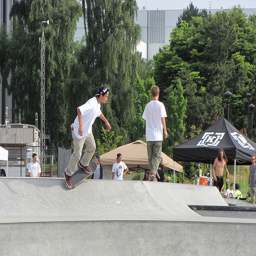

In [27]:
print(type(train_captions), len(train_captions), type(train_captions[0]))
print()
print(train_captions[0])
Image.open(img_names_vector[0]).resize((256, 256))

In [73]:
# Save these captions and img_names_vectors as pickles.  
path = '/mnt/c/Users/johan/Data_Science/Bachelor/bilingual-image-captioning/'
pickle.dump(train_captions, open(path+'train_captions.pickle' , 'wb' )) 
pickle.dump(img_names_vector, open(path+'img_names_vector.pickle' , 'wb' ))

In [74]:
train_captions = None
with open(path+'train_captions.pickle', 'rb') as handle:
    train_captions = pickle.load(handle)
img_name_vector = None
with open(path+'img_names_vector.pickle', 'rb') as handle:
    img_names_vector = pickle.load(handle)
print(len(train_captions), len(img_names_vector))

100 100


# Storing english captions in xlsx file

In [75]:
import xlsxwriter
workbook = xlsxwriter.Workbook(path+'English.xlsx') 
worksheet = workbook.add_worksheet() 

for i, each in enumerate(train_captions):
    if len(each) != 0:
        worksheet.write('A' + str(i+1), each[8:-6]) #To write each caption in column A, row i+1

# Finally, close the Excel file 
# via the close() method. 
workbook.close() 

# Getting Danish Captions

In [76]:
print(len(train_captions), type(train_captions), train_captions[:5])

100 <class 'list'> ['<start> A skateboarder performing a trick on a skateboard ramp. <end>', '<start> a person soaring through the air on skis <end>', '<start> a wood door with some boards laid against it <end>', '<start> A Do Not Enter sign is posted along a road leading to a stadium. <end>', '<start> Small child in a high chair eating off of a green plate.  <end>']


In [77]:
import six
from google.cloud import translate_v2 as translate
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/mnt/c/Users/johan/Data_Science/Bachelor/bilingual-image-captioning/My Project 55093-fccd3cabb42a.json"

In [78]:
def translate_text(target, text):
    """Translates text into the target language.

    Target must be an ISO 639-1 language code.
    See https://g.co/cloud/translate/v2/translate-reference#supported_languages
    """
    

    translate_client = translate.Client()

    if isinstance(text, six.binary_type):
        text = text.decode("utf-8")

    # Text can also be a sequence of strings, in which case this method
    # will return a sequence of results for each text.
    result = translate_client.translate(text, target_language=target)
    
    return result['translatedText']

In [79]:
def translate(captions):
    translations = []
    for i in range(len(train_captions)):
        if i % 2000 == 0 and i != 0:
            print(i)
            time.sleep(100) #requests measured every 100 seconds. 
        translation = translate_text('da', train_captions[i])
        translations.append(translation)
    return translations

In [80]:
# Translating done here

#translations = translate(train_captions)

#with open(path+'Danish_captions.txt', "w") as file:
#    for translation in translations:
#        file.write(translation)
#        file.write("\n")

In [81]:
train_captions_danish = open(path+"Danish_captions.txt", "r").read().split('\n')[:100]#Danish_captions.txt are 30 000 captions
#train_captions_danish.remove('') -> only needed if we use all 30 000 captions. 
print(len(train_captions_danish))

100


In [82]:
print(list(zip(train_captions_danish, train_captions))[:5]) #Check to see if english and danish captions match

[('<start>En skateboarder udfører et trick på en skateboardrampe.<end>', '<start> A skateboarder performing a trick on a skateboard ramp. <end>'), ('<start>en person, der skyder gennem luften på ski<end>', '<start> a person soaring through the air on skis <end>'), ('<start>en trædør med nogle brædder lagt mod den<end>', '<start> a wood door with some boards laid against it <end>'), ('<start>Et Indtast ikke-tegn er anbragt langs en vej, der fører til et stadion.<end>', '<start> A Do Not Enter sign is posted along a road leading to a stadium. <end>'), ('<start>Lille barn i en høj stol, der spiser af en grøn plade.<end>', '<start> Small child in a high chair eating off of a green plate.  <end>')]


# Loading images

In [83]:
#each Keras Application expects a specific kind of input preprocessing. 
#For InceptionV3, call tf.keras.applications.inception_v3.preprocess_input on your inputs before passing them to the model.

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img, image_path

In [156]:
#include_top = whether to include the fully-connected layer at the top, as the last layer of the network. Default to True.
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet') #loads weights pre-trained on ImageNet.

#The shape of the output of this layer is 8x8x2048 -> after last conv layer in the V3 model. Rest has not been included.
#You use the last convolutional layer because you are using attention in this example. 
#You don't perform this initialization during training because it could become a bottleneck.

new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [157]:
image_features_extract_model.output_shape

(None, None, None, 2048)

In [158]:
print(new_input)
print(hidden_layer)
print(image_features_extract_model)

Tensor("input_4:0", shape=(None, None, None, 3), dtype=float32)
Tensor("mixed10/concat_3:0", shape=(None, None, None, 2048), dtype=float32)


#### Preprocess of images using InceptionV3

In [86]:
from tqdm import tqdm

In [161]:
# Get unique images
unique_img_names_vector = sorted(set(img_names_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(unique_img_names_vector) #image_dataset is an iterable of images, reads images here
print(image_dataset)

image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16) #batch(multi-element) image_dataset transformations

<TensorSliceDataset shapes: (), types: tf.string>


In [162]:
print("Shape of input images: ", image_dataset)

Shape of input images:  <BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>


In [89]:
type(image_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [190]:
for img, path in tqdm(image_dataset):
    #img shape: (16, 299, 299, 3) which the V3 model expects. Format: (batch, img shape)
    
    batch_features = image_features_extract_model(img) #shape: (16, 8, 8, 2048) img: (8, 8, 2048) -> after last conv layer
    
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3])) #shape: (16, 64, 2048)
    
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 7/7 [00:10<00:00,  1.53s/it]


# Preprocessin, tokenizing and splitting

- First, you'll tokenize the captions (for example, by splitting on spaces)
- Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
- You then create word-to-index and index-to-word mappings.
- Finally, you pad all sequences to be the same length as the longest one.

In [92]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [93]:
# Choose the top 5000 words from the vocabulary
top_k = 5000

english_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
english_tokenizer.fit_on_texts(train_captions)
english_tokenizer.word_index['<pad>'] = 0
english_tokenizer.index_word[0] = '<pad>'
train_seqs = english_tokenizer.texts_to_sequences(train_captions)


danish_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
danish_tokenizer.fit_on_texts(train_captions_danish)
danish_tokenizer.word_index['<pad>'] = 0
danish_tokenizer.index_word[0] = '<pad>'
train_seqs_danish = danish_tokenizer.texts_to_sequences(train_captions_danish)

In [95]:
print(len(train_captions) == len(train_captions_danish))
print(len(english_tokenizer.word_index))

True
421


In [96]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
cap_vector_danish = tf.keras.preprocessing.sequence.pad_sequences(train_seqs_danish, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs + train_seqs_danish) #get max length sentence from combined corpora

In [97]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val, cap_danish_train, cap_danish_val = train_test_split(img_names_vector, cap_vector, cap_vector_danish, test_size=0.2, random_state=0)

In [98]:
len(img_name_train), len(img_name_val), len(cap_train), len(cap_val), len(cap_danish_train), len(cap_danish_val)

(80, 20, 80, 20, 80, 20)

# Create a tf.data dataset for training

In [99]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
vocab_size_d = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [100]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [102]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Model
Fun fact: the decoder below is identical to the one in the example for Neural Machine Translation with Attention.

The model architecture is inspired by the Show, Attend and Tell paper.

- In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
- You squash that to a shape of (64, 2048).
- This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
- The RNN (here GRU) attends over the image to predict the next word.

In [104]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [105]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [106]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [107]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [108]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [109]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [110]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

# Training 

- You extract the features stored in the respective .npy files and then pass those features through the encoder.
- The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
- The decoder returns the predictions and the decoder hidden state.
- The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
- Use teacher forcing to decide the next input to the decoder.
- Teacher forcing is the technique where the target word is passed as the next input to the decoder.
- The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [111]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [112]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([english_tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [115]:
EPOCHS = 3

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset): #batch: 64 images, 
                                                             #img_tensor: (number of images, img dimensions(64, 2048))
        batch_loss, t_loss = train_step(img_tensor, target)  #target: caption vectors of len = max length
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 2 Batch 0 Loss 3.1646
Epoch 2 Loss 6.182553
Time taken for 1 epoch 22.668363332748413 sec

Epoch 3 Batch 0 Loss 3.0230
Epoch 3 Loss 5.952215
Time taken for 1 epoch 1.333693504333496 sec



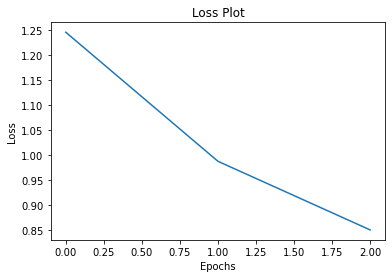

In [148]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [153]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([english_tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(english_tokenizer.index_word[predicted_id])

        if english_tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [154]:
real_captions = []
for rid in range(0, len(cap_val)):
    real_captions.append(' '.join([english_tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])[7:-8].split())
print(len(real_captions))

2000


In [155]:
predicted_captions = []
for i, image in tqdm(enumerate(img_name_val)):
    result, attention_plot = evaluate(image)
    result = ' '.join(result)[:-8]
    predicted_captions.append(result.split())
print(len(predicted_captions))

2000it [08:15,  4.03it/s]

2000


In [198]:
from nltk.translate.bleu_score import corpus_bleu

print(' BLEU-1: %f' % corpus_bleu(real_captions, predicted_captions, weights=(1.0, 0, 0, 0)))
print(' BLEU-2: %f' % corpus_bleu(real_captions, predicted_captions, weights=(0.5, 0.5, 0, 0)))
print(' BLEU-3: %f' % corpus_bleu(real_captions, predicted_captions, weights=(0.3, 0.3, 0.3, 0)))
print(' BLEU-4: %f' % corpus_bleu(real_captions, predicted_captions, weights=(0.25, 0.25, 0.25, 0.25)))

 BLEU-1: 0.091017
 BLEU-2: 0.002185
 BLEU-3: 0.000000
 BLEU-4: 0.000000


In [199]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a giraffe is standing by a fence in the grass <end>
Prediction Caption: a brown small bird is on a forest in a pen on a tree out near a lawn <end>


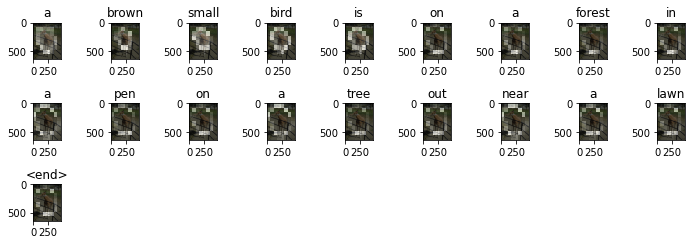

In [200]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([english_tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Prediction Caption: a man riding a surfboard using the ocean <end>


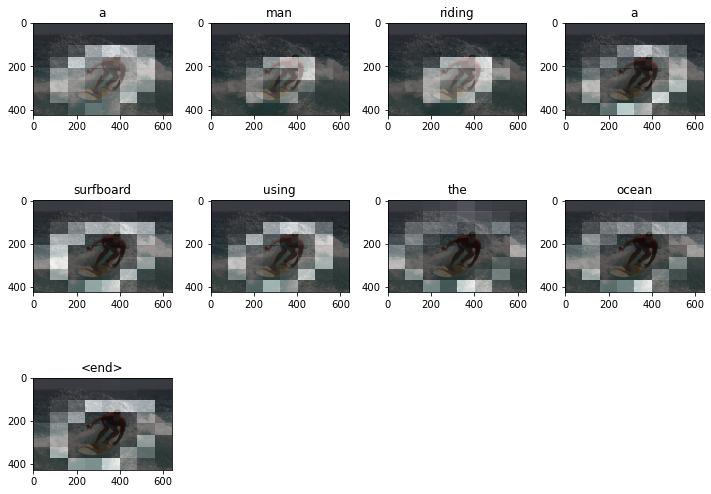

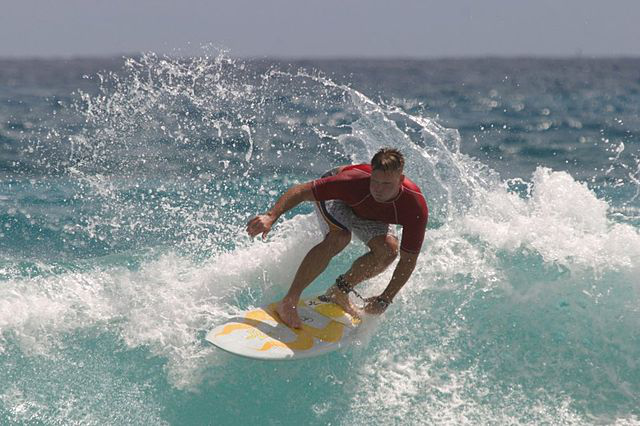

In [203]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)